# EE399 HW6
## Ziwen


https://github.com/ZiwenLi0325/EE399.git

In [1]:
import numpy as np
from processdata import load_data
from processdata import TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler



In [2]:
num_sensors = 3 
lags = 52
load_X = load_data("SST")
print(load_X.shape)
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)
train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)



(1400, 44219)


In [3]:
### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)
shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

Training epoch 1
Error tensor(0.4836)
Training epoch 20
Error tensor(0.2294)
Training epoch 40
Error tensor(0.2215)
Training epoch 60
Error tensor(0.2178)
Training epoch 80
Error tensor(0.2176)
Training epoch 100
Error tensor(0.2171)
Training epoch 120
Error tensor(0.2156)
Training epoch 140
Error tensor(0.2132)
Training epoch 160
Error tensor(0.2118)
Training epoch 180
Error tensor(0.2050)
Training epoch 200
Error tensor(0.2011)
Training epoch 220
Error tensor(0.1948)
Training epoch 240
Error tensor(0.1754)
Training epoch 260
Error tensor(0.1594)
Training epoch 280
Error tensor(0.1499)
Training epoch 300
Error tensor(0.1435)
Training epoch 320
Error tensor(0.1400)
Training epoch 340
Error tensor(0.1351)
Training epoch 360
Error tensor(0.1315)
Training epoch 380
Error tensor(0.1296)
Training epoch 400
Error tensor(0.1272)
Training epoch 420
Error tensor(0.1247)
Training epoch 440
Error tensor(0.1245)
Training epoch 460
Error tensor(0.1222)
Training epoch 480
Error tensor(0.1200)
Traini

KeyboardInterrupt: 

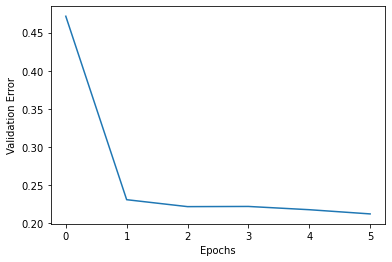

In [ ]:
plt.plot(range(len(validation_errors)), validation_errors)
plt.xlabel('Epochs')
plt.ylabel('Validation Error')
plt.title('Validation Error vs. Epochs')
plt.savefig('SST_validation_error.png') 
plt.show()

Training epoch 1
Error tensor(0.4722)
Training epoch 20
Error tensor(0.2320)
Training epoch 40
Error tensor(0.2224)
Training epoch 60
Error tensor(0.2210)
Training epoch 80
Error tensor(0.2172)
Training epoch 100
Error tensor(0.2100)
Training epoch 1
Error tensor(0.4713)
Training epoch 20
Error tensor(0.2312)
Training epoch 40
Error tensor(0.2216)
Training epoch 60
Error tensor(0.2207)
Training epoch 80
Error tensor(0.2161)
Training epoch 100
Error tensor(0.2100)
Training epoch 1
Error tensor(0.4722)
Training epoch 20
Error tensor(0.2348)
Training epoch 40
Error tensor(0.2227)
Training epoch 60
Error tensor(0.2211)
Training epoch 80
Error tensor(0.2198)
Training epoch 100
Error tensor(0.2106)
Training epoch 1
Error tensor(0.4714)
Training epoch 20
Error tensor(0.2309)
Training epoch 40
Error tensor(0.2215)
Training epoch 60
Error tensor(0.2205)
Training epoch 80
Error tensor(0.2128)
Training epoch 100
Error tensor(0.2070)
Training epoch 1
Error tensor(0.4728)
Training epoch 20
Error te

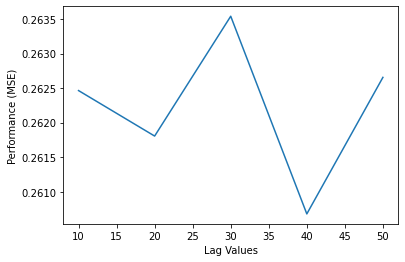

In [ ]:
lag_values = [10, 20, 30, 40, 50]  # Define a list of different lags values
performance_lag = []

for lag in lag_values:
    # Rest of the data preprocessing part remains same, just replace 'lags' with 'lag'
    # ...
    # train the model
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)
    # Calculate performance, let's assume it's Mean Squared Error (MSE) for this case
    performance = np.mean(validation_errors)
    performance_lag.append(performance)




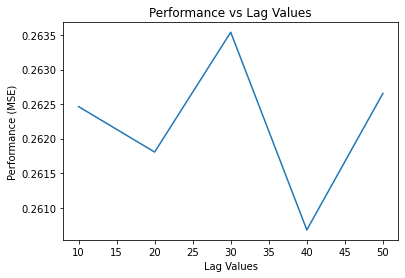

In [ ]:
# Plotting
plt.plot(lag_values, performance_lag)
plt.xlabel('Lag Values')
plt.ylabel('Performance (MSE)')
plt.title('Performance vs Lag Values')
plt.savefig('lag_performance.png')
plt.show()

In [ ]:
# Define different scales of noise you want to test
noise_scales = [0.0, 0.1, 0.2, 0.5, 1.0, 2.0]

# Define a list to store the performance results for each noise scale
performance_results_noise = []

for noise_scale in noise_scales:
    # Add Gaussian noise to your original data
    noisy_data_in = train_data_in + torch.normal(mean=0.0, std=noise_scale, size=train_data_in.shape, device=device)
    noisy_valid_data_in = valid_data_in + torch.normal(mean=0.0, std=noise_scale, size=valid_data_in.shape, device=device)

    # Create noisy datasets
    noisy_train_dataset = TimeSeriesDataset(noisy_data_in, train_data_out)
    noisy_valid_dataset = TimeSeriesDataset(noisy_valid_data_in, valid_data_out)

    # Train the model
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, noisy_train_dataset, noisy_valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)
    
    # Calculate performance
    performance = np.mean(validation_errors)
    performance_results_noise.append(performance)



Training epoch 1
Error tensor(0.4716)
Training epoch 20
Error tensor(0.2304)
Training epoch 40
Error tensor(0.2241)
Training epoch 60
Error tensor(0.2208)
Training epoch 80
Error tensor(0.2166)
Training epoch 100
Error tensor(0.2083)
Training epoch 1
Error tensor(0.4721)
Training epoch 20
Error tensor(0.2288)
Training epoch 40
Error tensor(0.2231)
Training epoch 60
Error tensor(0.2226)
Training epoch 80
Error tensor(0.2203)
Training epoch 100
Error tensor(0.2118)
Training epoch 1
Error tensor(0.4721)
Training epoch 20
Error tensor(0.2270)
Training epoch 40
Error tensor(0.2239)
Training epoch 60
Error tensor(0.2254)
Training epoch 80
Error tensor(0.2225)
Training epoch 100
Error tensor(0.2219)
Training epoch 1
Error tensor(0.4730)
Training epoch 20
Error tensor(0.2427)
Training epoch 40
Error tensor(0.2368)
Training epoch 60
Error tensor(0.2343)
Training epoch 80
Error tensor(0.2385)
Training epoch 100
Error tensor(0.2394)
Training epoch 1
Error tensor(0.4788)
Training epoch 20
Error te

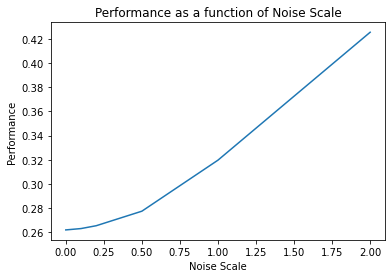

In [ ]:
# Plot the performance results as a function of the noise scale
plt.plot(noise_scales, performance_results_noise)
plt.xlabel('Noise Scale')
plt.ylabel('Performance')
plt.title('Performance as a function of Noise Scale')
plt.savefig('noise_scale_performance.png')
plt.show()

In [ ]:
# Define different numbers of sensors to test
sensor_counts = range(1, num_sensors+1)

# Define a list to store the performance results for each number of sensors
performance_results_sensor = []

for sensor_count in sensor_counts:
    # Reshape your data to include the appropriate number of sensors
    reshaped_train_data_in = train_data_in[:, :, :sensor_count]
    reshaped_valid_data_in = valid_data_in[:, :, :sensor_count]

    # Create new datasets with the modified number of sensors
    reshaped_train_dataset = TimeSeriesDataset(reshaped_train_data_in, train_data_out)
    reshaped_valid_dataset = TimeSeriesDataset(reshaped_valid_data_in, valid_data_out)

    # Train the model
    shred = models.SHRED(sensor_count, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, reshaped_train_dataset, reshaped_valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)
    
    # Calculate performance
    performance = np.mean(validation_errors)
    performance_results_sensor.append(performance)


Training epoch 1
Error tensor(0.4722)
Training epoch 20
Error tensor(0.2334)
Training epoch 40
Error tensor(0.2243)
Training epoch 60
Error tensor(0.2237)
Training epoch 80
Error tensor(0.2231)
Training epoch 100
Error tensor(0.2234)
Training epoch 1
Error tensor(0.4726)
Training epoch 20
Error tensor(0.2311)
Training epoch 40
Error tensor(0.2239)
Training epoch 60
Error tensor(0.2243)
Training epoch 80
Error tensor(0.2151)
Training epoch 100
Error tensor(0.2109)
Training epoch 1
Error tensor(0.4732)
Training epoch 20
Error tensor(0.2310)
Training epoch 40
Error tensor(0.2228)
Training epoch 60
Error tensor(0.2203)
Training epoch 80
Error tensor(0.2136)
Training epoch 100
Error tensor(0.2088)


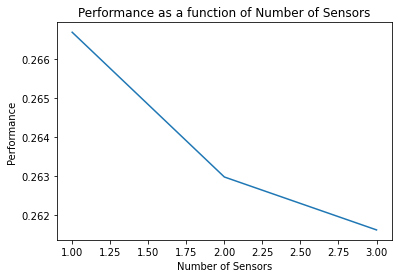

In [ ]:
# Plot the performance results as a function of the number of sensors
plt.plot(sensor_counts, performance_results_sensor)
plt.xlabel('Number of Sensors')
plt.ylabel('Performance')
plt.title('Performance as a function of Number of Sensors')
plt.savefig('performance_Sensors.png')
plt.show()